# バンディットアルゴリズムの比較
* トンプソンサンプリングを調べるために

Ref : https://blog.albert2005.co.jp/2017/01/23/

In [111]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [76]:
class BernoulliArm():
 
    def __init__(self, p):
        self.p = p
 
    def draw(self):
        if np.random.rand() > self.p:
            return 0.0
        else:
            return 1.0

class EpsilonGreedy():
 
    def __init__(self, epsilon, counts, values):
        self.epsilon = epsilon
        self.counts = counts
        self.values = values
 
    def initialize(self, n_arms):
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)
 
    def select_arm(self):
        if random.random() > self.epsilon:
            return np.argmax(self.values)
        else:
            return random.randint(0, len(self.values) - 1)
 
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
        self.values[chosen_arm] = new_value
 
class UCB():
 
    def __init__(self, counts, values):
        self.counts = counts
        self.values = values
 
    def initialize(self, n_arms):
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)
 
    def select_arm(self):
        n_arms = len(self.counts)
        if min(self.counts) == 0:
            return np.argmin(self.counts)
 
        total_counts = sum(self.counts)
        bonus = np.sqrt((np.log(np.array(total_counts))) /
                        2 / np.array(self.counts))
        ucb_values = np.array(self.values) + bonus
        return np.argmax(ucb_values)
 
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
        self.values[chosen_arm] = new_value        
        
class ThompsonSampling():
    def __init__(self, counts_alpha, counts_beta, values):
        self.counts_alpha = counts_alpha
        self.counts_beta = counts_beta
        self.alpha = 1
        self.beta = 1
        self.values = values
 
    def initialize(self, n_arms):
        self.counts_alpha = np.zeros(n_arms)
        self.counts_beta = np.zeros(n_arms)
        self.values = np.zeros(n_arms)
 
    def select_arm(self):
        """
        N個のarmからアタリを引く確率が一番高いarmを選ぶ
        
        Returns
        -------
        best_arm_index : int
            アタリを引く確率が一番高いarmのindex
        """
        theta = [(
            arm,
            np.random.beta(self.counts_alpha[arm] + self.alpha, self.counts_beta[arm] + self.beta))
            for arm in range(len(self.counts_alpha)
        )]
        theta = sorted(theta, key=lambda x: x[1])
        best_arm_index = theta[-1][0]
        return(best_arm_index)
 
    def update(self, chosen_arm, reward):
        """
        当たり(reward = 1)なら、alpha + 1。ハズレならbeta + 1
        
        """
        if reward == 1:
            self.counts_alpha[chosen_arm] += 1
        else:
            self.counts_beta[chosen_arm] += 1
        #n = float(self.counts_alpha[chosen_arm]) + self.counts_beta[chosen_arm]
        #self.values[chosen_arm] = (n - 1) / n * self.values[chosen_arm] + 1 / n * reward

In [77]:
def test_algorithm(algo, arms, num_sims, horizon):
    chosen_arms = np.zeros(num_sims * horizon)
    cumulative_rewards = np.zeros(num_sims * horizon)
    times = np.zeros(num_sims * horizon)
    for sim in range(num_sims):
        algo.initialize(len(arms))
        for t in range(horizon):
            index = sim * horizon + t
            times[index] = t + 1
            chosen_arm = algo.select_arm()
            chosen_arms[index] = chosen_arm
            reward = arms[chosen_arm].draw()
            if t == 0:
                cumulative_rewards[index] = reward
            else:
                cumulative_rewards[index] = cumulative_rewards[
                    index - 1] + reward
            algo.update(chosen_arm, reward)
    return [times, chosen_arms, cumulative_rewards]

In [110]:
n_arms = 10
means = [0.054,  0.069,  0.080,  0.097,  0.112,  0.119,  0.121,  0.144,  0.155,  0.174]
epsilon = 0.2  
sim_num = 500  # シミュレーション回数
time = 10000  # 試行回数
 
arms = list(map(lambda x: BernoulliArm(x), means))
 
algo_2 = EpsilonGreedy(epsilon, [], [])  # epsilon-greedy
algo_3 = UCB([], [])                    # UCB
algo_4 = ThompsonSampling([], [], [])   # ThompsonSampling
heights = []
np.random.seed(2017)

In [92]:
algo_2.initialize(n_arms)
result_2 = test_algorithm(algo_2, arms, sim_num, time)
df_result_2 = pd.DataFrame({"times": result_2[0], "chosen_arms": result_2[1]})
df_result_2["best_arms"] = (df_result_2["chosen_arms"] == np.argmax(means)).astype(int)
grouped_2 = df_result["best_arms"].groupby(df_result_2["times"])

In [93]:
algo_3.initialize(n_arms)
result_3 = test_algorithm(algo_3, arms, sim_num, time)
df_result_3 = pd.DataFrame({"times": result_3[0], "chosen_arms": result_3[1]})
df_result_3["best_arms"] = (df_result_3["chosen_arms"] == np.argmax(means)).astype(int)
grouped_3 = df_result_3["best_arms"].groupby(df_result_3["times"])

In [94]:
algo_4.initialize(n_arms)
result_4 = test_algorithm(algo_4, arms, sim_num, time)
df_result_4 = pd.DataFrame({"times": result_4[0], "chosen_arms": result_4[1]})
df_result_4["best_arms"] = (df_result_4["chosen_arms"] == np.argmax(means)).astype(int)
grouped_4 = df_result_4["best_arms"].groupby(df_result_4["times"])

In [105]:
heights = []
heights.append(result_2[2][-1])
heights.append(result_3[2][-1])
heights.append(result_4[2][-1])

ベストアームを選べてる

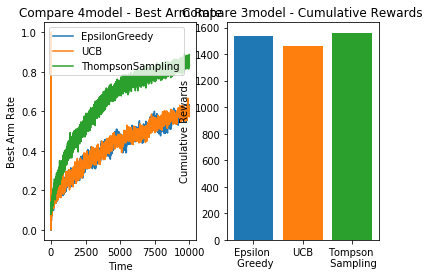

In [109]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(grouped_2.mean(), label=algo_2.__class__.__name__)
ax1.plot(grouped_3.mean(), label=algo_3.__class__.__name__)
ax1.plot(grouped_4.mean(), label=algo_4.__class__.__name__)
ax1.set_title("Compare 4model - Best Arm Rate")
ax1.set_xlabel("Time")
ax1.set_ylabel("Best Arm Rate")
ax1.legend(loc="upper left")
plt_label = ["Epsilon \n Greedy", "UCB", "Tompson \n Sampling"]
plt_color = ["muted", "pastel", "bright"]
ax2.bar(range(1, 4), heights, color=sns.color_palette()[:3], align="center")
ax2.set_xticks(range(1, 4))
ax2.set_xticklabels(plt_label)
ax2.set_label("random_select")
ax2.set_ylabel("Cumulative Rewards")
ax2.set_title("Compare 3model - Cumulative Rewards")

plt.show()

以下はメモ

In [64]:
chosen_arms = np.zeros(num_sims * horizon)
cumulative_rewards = np.zeros(num_sims * horizon)
times = np.zeros(num_sims * horizon)
for sim in range(num_sims):
    algo.initialize(len(arms))
    for t in range(horizon):
        index = sim * horizon + t
        times[index] = t + 1
        chosen_arm = algo.select_arm()
        chosen_arms[index] = chosen_arm
        reward = arms[chosen_arm].draw()
        if t == 0:
            cumulative_rewards[index] = reward
        else:
            cumulative_rewards[index] = cumulative_rewards[index - 1] + reward
        algo.update(chosen_arm, reward)

In [65]:
algo.counts_alpha

array([ 2.,  0.,  3.,  3.,  7., 26., 15., 23., 32.,  8.])

In [66]:
algo.counts_beta

array([ 34.,  25.,  45.,  39.,  64., 174., 109., 129., 195.,  67.])

In [67]:
chosen_arms

array([1., 6., 9., ..., 5., 8., 0.])

In [69]:
df_result = pd.DataFrame({"times": times, "chosen_arms": chosen_arms})
df_result["best_arms"] = (df_result["chosen_arms"] == np.argmax(means)).astype(int)

1000回目くらいにはbest armを選べる確率が35%くらいになっている

In [88]:
grouped = df_result["best_arms"].groupby(df_result["times"])
grouped.mean()

times
1.0        0.000
2.0        0.000
3.0        0.000
4.0        0.000
5.0        0.000
6.0        0.000
7.0        0.000
8.0        0.000
9.0        0.000
10.0       1.000
11.0       0.064
12.0       0.146
13.0       0.068
14.0       0.090
15.0       0.040
16.0       0.026
17.0       0.012
18.0       0.004
19.0       0.000
20.0       0.122
21.0       0.230
22.0       0.270
23.0       0.218
24.0       0.204
25.0       0.114
26.0       0.106
27.0       0.072
28.0       0.078
29.0       0.046
30.0       0.068
           ...  
9971.0     0.628
9972.0     0.622
9973.0     0.610
9974.0     0.612
9975.0     0.598
9976.0     0.620
9977.0     0.614
9978.0     0.616
9979.0     0.608
9980.0     0.606
9981.0     0.622
9982.0     0.626
9983.0     0.630
9984.0     0.626
9985.0     0.606
9986.0     0.610
9987.0     0.616
9988.0     0.622
9989.0     0.602
9990.0     0.612
9991.0     0.616
9992.0     0.618
9993.0     0.618
9994.0     0.606
9995.0     0.612
9996.0     0.630
9997.0     0.628
9998.0  

In [75]:
cumulative_rewards

array([  0.,   0.,   0., ..., 118., 118., 119.])